# Multiclass Classification

In [15]:
#import dependencies
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, cross_val_predict

In [3]:
mnist = fetch_openml('mnist_784', as_frame=False) 
X, y = mnist.data, mnist.target
some_input = X[0] #this is a 5
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

/Users/Cheks/opt/anaconda3/envs/python/lib/python3.9/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [4]:
#train a support vector machine classifier on the first 2000 instances to save time
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000]) #sklearn uses the OvO strategy here (more than 2 classes)

SVC(random_state=42)

In [5]:
#what does svc predict?
svm_clf.predict([some_input]) #predicts a 5 - correct!

array(['5'], dtype=object)

In [6]:
#also check the scores using the .decision_function() method
some_digit_scores = svm_clf.decision_function([some_input])
some_digit_scores.round(2) #highest score corresponds to 5

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [7]:
#trained classifiers store the list of target classes in the classes_ attribute, ordered by value
svm_clf.classes_
#obtain the class with the highest value
class_id = some_digit_scores.argmax()
#what class?
svm_clf.classes_[class_id]

'5'

In [8]:
#force sklearn to use either OvO or OvR by creating an instance and passing a classifier into its constructor:
ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [9]:
ovr_clf.predict([some_input]) #predicts 5

array(['5'], dtype='<U1')

In [10]:
#how many estimators did we make using OvR? 
len(ovr_clf.estimators_) #10, as expected

10

Scaling the inputs using StandardScaler() can improve performance.

In [14]:
#no scaling
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_input]) #predicts 3

array(['3'], dtype='<U1')

In [12]:
#accuracy of non scaled classifier
cv_accuracy_scores = cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring= "accuracy") #there are roughly the same number of instances in each class so accuracy metric is fine.

In [13]:
cv_accuracy_scores #over 85.8% on all three test folds

array([0.87365, 0.85835, 0.8689 ])

In [17]:
#scaling 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy') #mininum accuracy of 89.1% for each fold!

array([0.8983, 0.891 , 0.9018])

## Error Analysis

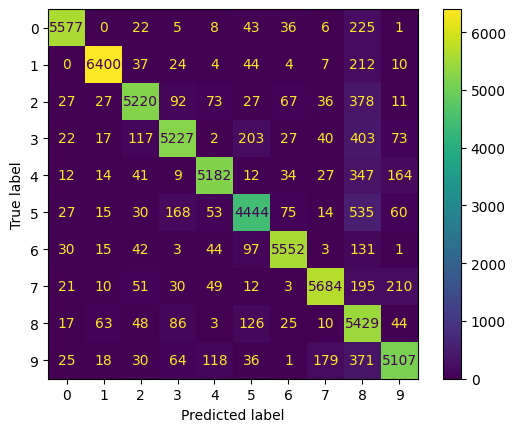

In [18]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

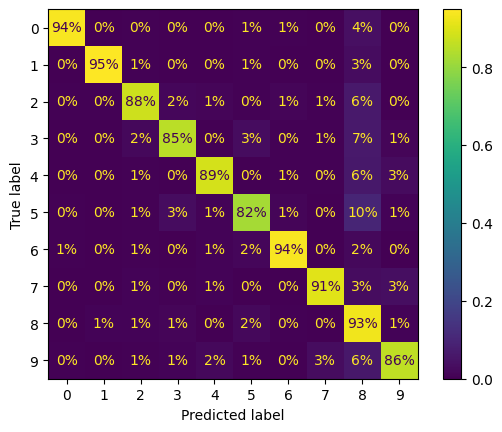

In [20]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize='true', values_format=".0%") #format to obtain percentages with no decimals
#setting normalise = 'true' divides the number in each cell by the total number of instances in that class. helps visualise how many errors for each class.
#5s were often misclassified as 8s. but only 2% of 8s are misclassified as 5s.


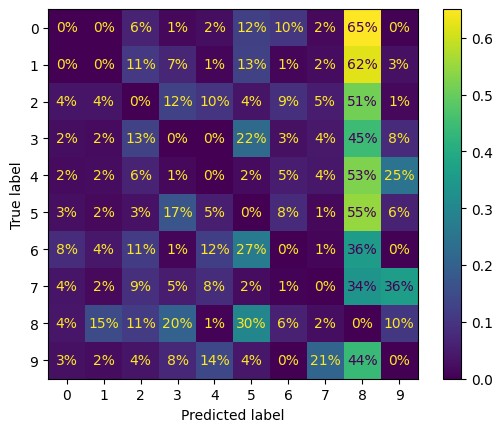

In [21]:
#you can put zero weight on the correct predictions to make errors stand out more
sample_weight = (y_train_pred != y_train) #0 when correct, 1 when incorrect
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_weight, normalize='true', values_format=".0%")
#confirms that many images are misclassified as 8s. e.g. 65% of the errors for 0s were misclassified as 8s.
#remember that this refers to the percentage of ERRORS and not of images 

Text(0.5, 1.0, 'Errors normalized by columns')

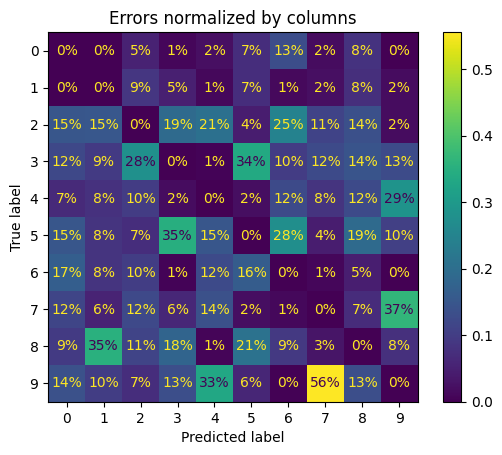

In [24]:
#normalise by column by setting normalise = 'pred'
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_weight, normalize='pred', values_format=".0%")
#here we can see that 56% of images misclassified as 7s are actually 9s
plt.title("Errors normalized by columns")

### Interpreting the results

Probably gather more training data for digits that look like 8s but are not so that 